# InfoGAN demo

cGAN and cVAE both rely on supervised training to have control over features (defined by labels) of generated data. InfoGAN, on the other hand, does not require labels and instead extracts latent features using an autoencoder-like architecture called auxiliary model. This allows InfoGAN to disentangle latent space when data properties is not given.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(images_train, label), (images_test, label_test) = mnist.load_data()
images_train = images_train[...,np.newaxis] / 255.0
images_test = images_test[...,np.newaxis] / 255.0
images_train.shape

(60000, 28, 28, 1)

In [3]:
def generator(latent_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input([latent_dim]),
        tf.keras.layers.Dense(units=(7 * 7 * 256), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=5,
            strides=1,
            padding='same',
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=5,
            strides=2,
            padding='same',
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=5,
            strides=2,
            padding='same',
            use_bias=False,
            activation='sigmoid',
        ),
    ])


def discriminator_auxiliary(conditional_dim, categorical_dim):
    inp = tf.keras.layers.Input([28, 28, 1])
    
    # shared
    x = tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=5, 
                               strides=2,
                               padding='same')(inp)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)    
    
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=5, 
                               strides=2,
                               padding='same')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    # discriminator 
    d = tf.keras.layers.Conv2D(filters=128,
                               kernel_size=7, 
                               strides=1, 
                               padding='valid')(x)
    d = tf.keras.layers.LayerNormalization()(d)
    d = tf.keras.layers.LeakyReLU()(d)

    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(64)(d)
    d = tf.keras.layers.Dense(1)(d)
    
    disc = tf.keras.Model(inp, d)

    # auxiliary   
    q = tf.keras.layers.Conv2D(filters=128,
                               kernel_size=7, 
                               strides=1, 
                               padding='valid')(x)
    q = tf.keras.layers.LayerNormalization()(q)
    q = tf.keras.layers.LeakyReLU()(q)
    
    q = tf.keras.layers.Flatten()(q)
    q = tf.keras.layers.Dense(64)(q)
    q = tf.keras.layers.Dense(conditional_dim)(q)

    softmax = tf.keras.activations.softmax(q[:, :categorical_dim], -1)
    q = tf.concat([softmax, q[:, categorical_dim:]], -1)
    
    auxiliary = tf.keras.Model(inp, q)
    
    return disc, auxiliary

In [12]:
class GAN(tf.keras.Model):

    def __init__(self, 
                 latent_dim, 
                 conditional_dim, 
                 categorical_dim, 
                 gp_weight=10, 
                 disc_steps=3):
        super().__init__()
        self.gp_weight = gp_weight
        self.disc_steps = disc_steps
        
        self.latent_dim = latent_dim
        self.conditional_dim = conditional_dim
        self.categorical_dim = categorical_dim
                
        self.discriminator, self.auxiliary = discriminator_auxiliary(self.conditional_dim, 
                                                                     self.categorical_dim)
        self.generator = generator(self.latent_dim)
        
    def gradient_penalty(self, real, fake):
        batch_size = tf.shape(real)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @staticmethod
    def discriminator_loss(real_logits, fake_logits):
        real_loss = tf.reduce_mean(real_logits)
        fake_loss = tf.reduce_mean(fake_logits)
        return fake_loss - real_loss
    
    @staticmethod
    def cat_loss(c_true, c_pred):
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(c_true, c_pred))
    
    @staticmethod
    def l2_loss(c_true, c_pred):    
        return tf.reduce_mean((c_true-c_pred)**2)
    
    @staticmethod
    def generator_loss(fake_logits):
        return -tf.reduce_mean(fake_logits)
    
    def train_step(self, inputs):
        real = inputs
        
        disc_vars = self.discriminator.trainable_variables
        gen_vars = self.generator.trainable_variables 
        aux_vars = self.auxiliary.trainable_variables + self.generator.trainable_variables 

        for i in range(self.disc_steps): 
            random_category = tf.random.uniform(shape=(tf.shape(real)[0], ), minval=0, maxval=10, dtype=tf.int64)
            random_onehot = tf.one_hot(random_category, self.categorical_dim)
            
            noise = tf.random.normal(shape=[tf.shape(real)[0], self.latent_dim-self.categorical_dim])
            noise = tf.concat([random_onehot, noise], -1)
            
            with tf.GradientTape() as disc_tape:
                fake = self.generator(noise, training=True)
                real_logits = self.discriminator(real, training=True)
                fake_logits = self.discriminator(fake, training=True)
                disc_loss = self.discriminator_loss(real_logits, fake_logits)
                disc_loss += self.gp_weight * self.gradient_penalty(real, fake)

            disc_grads = disc_tape.gradient(disc_loss, disc_vars)
            self.optimizer.apply_gradients(zip(disc_grads, disc_vars))

        with tf.GradientTape() as gen_tape:
            fake = self.generator(noise, training=True)
            real_logits = self.discriminator(real, training=True)
            fake_logits = self.discriminator(fake, training=True)
            gen_loss = self.generator_loss(fake_logits)
            
        gen_grads = gen_tape.gradient(gen_loss, gen_vars)
        self.optimizer.apply_gradients(zip(gen_grads, gen_vars))

        with tf.GradientTape() as aux_tape:
            fake = self.generator(noise, training=True)
            condition = self.auxiliary(fake)
            
            true_condition = noise[:, :self.conditional_dim]
            true_category = true_condition[:, :self.categorical_dim]
            true_gaussian = true_condition[:, self.categorical_dim:]
            
            cat_loss = self.cat_loss(true_category, condition[:, :self.categorical_dim])
            l2_loss = self.l2_loss(true_gaussian, condition[:, self.categorical_dim:])
            auxiliary_loss = 10 * (cat_loss + l2_loss)
            
        aux_grads = aux_tape.gradient(auxiliary_loss, aux_vars)
        self.optimizer.apply_gradients(zip(aux_grads, aux_vars))
        
        return {'gen_loss': gen_loss,
                'disc_loss': disc_loss,
                'auxiliary_loss':auxiliary_loss}

In [15]:
latent_dim = 62
categorical_dim = 10 
gaussian_dim = 2
conditional_dim = categorical_dim + gaussian_dim
epochs = 2000
lr = 1e-3
batch_size = 256

model = GAN(latent_dim = latent_dim,
            categorical_dim = categorical_dim,
            conditional_dim = conditional_dim)

model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.9, learning_rate=lr))

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='gen_loss', 
                                                           min_delta=0, 
                                                           patience=20, 
                                                           restore_best_weights=True)      
model.fit(images_train, 
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[early_stopping_callback])

Epoch 1/50
235/235 [==============================] - 130s 555ms/step - gen_loss: -25.5077 - disc_loss: -1.0327 - auxiliary_loss: 0.3619
Epoch 2/50
235/235 [==============================] - 131s 556ms/step - gen_loss: -24.8381 - disc_loss: -1.0079 - auxiliary_loss: 0.3522
Epoch 3/50
235/235 [==============================] - 131s 557ms/step - gen_loss: -25.0849 - disc_loss: -1.0032 - auxiliary_loss: 0.3621
Epoch 4/50
235/235 [==============================] - 132s 560ms/step - gen_loss: -25.4054 - disc_loss: -0.9666 - auxiliary_loss: 0.3516
Epoch 5/50
235/235 [==============================] - 131s 555ms/step - gen_loss: -25.4341 - disc_loss: -0.9536 - auxiliary_loss: 0.3436
Epoch 6/50
235/235 [==============================] - 130s 555ms/step - gen_loss: -25.3988 - disc_loss: -0.9546 - auxiliary_loss: 0.3289
Epoch 7/50
235/235 [==============================] - 130s 555ms/step - gen_loss: -25.4216 - disc_loss: -0.9308 - auxiliary_loss: 0.3221
Epoch 8/50
235/235 [=====================

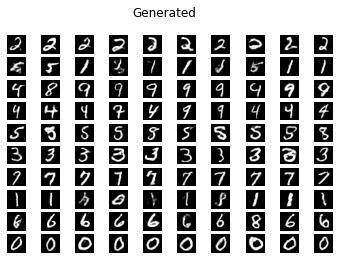

In [17]:
#display results
def img_grid(imgs, rows, cols, title, epoch=0):
    fig = plt.figure()
    for i, j in np.ndindex(rows, cols):
        plt.subplot(rows, cols, i*cols+j+1)
        plt.imshow(np.repeat(imgs[i*cols+j], 3, -1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# class Draw(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         gen = model.generator.predict(r)
#         img_grid(gen, rows, cols, 'Generated', 0)
        
# r = np.random.normal(size=(rows,cols,latent_dim))
# r[:,:, 10] =  np.linspace(-2, 2, cols)
# r[:, :, :10] = np.eye(10)[:, np.newaxis].repeat(cols, 1)
# r = r.reshape(-1, latent_dim)  

cols = 10
rows = 10
# inp = images_train[:cols*rows]
# img_grid(inp, rows, cols, 'Original')

r = np.random.normal(size=(rows,cols, latent_dim))
# r[:,:, 11] =  np.linspace(-3, 3, cols)
r[:, :, :10] = np.eye(10)[:, np.newaxis].repeat(cols, 1)
r = r.reshape(-1, latent_dim) 

gen = model.generator.predict(r)
img_grid(gen, rows, cols, 'Generated')